![CC-BY-SA](https://mirrors.creativecommons.org/presskit/buttons/88x31/svg/by-sa.svg)
This notebook was created by [Bernardo Freitas Paulo da Costa](http://www.im.ufrj.br/bernardofpc),
and is licensed under Creative Commons BY-SA

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

# Interpolação polinomial

Vimos que os métodos de integração podem ser obtidos através de _regras_ que,
dados alguns pontos no intervalo-padrão $[-1,1]$,
calculam o polinômio que passa por eles, e calcula a integral do polinômio correspondente.

Este procedimento de "passar um polinômio" por pontos dados é conhecido como interpolação polinomial

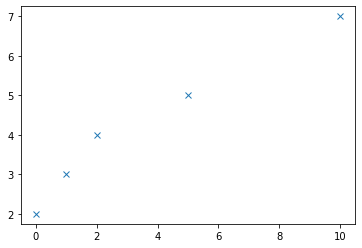

In [20]:
xs = [0,1,2,5,10]
ys = [2,3,4,5,7]
plt.plot(xs,ys, 'x')
plt.show()

## Interpolação e Álgebra Linear

A idéia fundamental da interpolação polinomial é que, dados $n+1$ pontos conhecidos,
existe apenas um polinômio de grau $n$ que passa por eles.
Este será o "melhor" polinômio de grau menor ou igual a $n$ que interpola estes dados,
e não faz muito sentido tentar achar polinômios de mais alto grau,
porque existem infinitos que vão passar pelos mesmos pontos!

Assim, temos que descobrir $n+1$ coeficientes - digamos $a_0, a_1, \ldots, a_n$ -
para o nosso polinômio, em função de $n+1$ pontos $x$ e $y$.
Ora, temos exatamente $n+1$ equações lineares nos coeficientes $a_j$:
$$ y_i = P(x_i) = \sum_{j=0}^n a_j x_i^j \quad\text{para $i=0\ldots n$.} $$
Portanto, dados $x_i$ e $y_i$, basta montar a matriz $M$ correspondente a este sistema linear,
e depois pedir para `np.linalg.solve()` retornar o vetor-solução contendo os $a_j$!

In [21]:
def lagrange_coefs(xs,ys):
    """ Calcula os coeficientes do polinômio interpolador dos pontos $(x_i, y_i)$. """
    assert(len(xs) == len(ys))
    
    Vandermonde = []
    for x in xs:
        vetor = []
        for i in range(len(xs)):
            vetor.append(x**i)
        Vandermonde.append(vetor)
    return np.linalg.solve(Vandermonde,ys)

In [22]:
lagrange_coefs([0,1,2], [0,1,4])

array([0., 0., 1.])

In [23]:
lagrange_coefs([0,1,2], [0,1,4])

array([0., 0., 1.])

In [24]:
lagrange_coefs([0,1,2], [2,6,12])

array([2., 3., 1.])

In [25]:
lagrange_coefs([10000,10001,10002], [2,6,12])

array([ 9.9970002e+07, -1.9997000e+04,  1.0000000e+00])

In [26]:
lagrange_coefs([-1,0,1,-2], [1,2,3,4])

array([ 2.        ,  1.66666667,  0.        , -0.66666667])

In [27]:
lagrange_coefs(xs, ys)

array([ 2.        ,  0.88055556,  0.18972222, -0.07555556,  0.00527778])

## Uma digressão: o método de Horner para calcular polinômios

Um polinômio é definido por seus $n+1$ coeficientes.
Imagine que você queira fazer uma função que calcula $P(x)$ dado um vetor de coeficientes.
Uma forma é usar a definição:
$$ P(x) = \sum _ {k=0}^n a_k x^k $$
que se traduz diretamente em código.
Mas este método faz "contas demais".
Note que ele faz $n$ multiplicações (para cada termo, menos o $i=0$), $n$ adições,
e ainda tem que calcular as potências de $x$.

A idéia é fazer as contas "ao contrário", pensando no polinômio da seguinte forma:
$$ P(x) = a_0 + xQ(x) = a_0 + x(a_1 + xR(x)) = \ldots = a_0 + x(a_1 + x(a_2 + x(\cdots + x\big(a _ {n-1} + x(a_n)\big) \cdots) )), $$
e operar "de dentro para fora dos parêntesis".
Este procedimento é conhecido como _método de Horner_ para polinômios.

In [28]:
def Horner(rcoeff):
    """ Método de Horner. Dados os coeficientes em ordem inversa, [a_n, ... a_1, a_0],
        retorna uma função que calcula o polinômio correspondente. """
        
    def p(x):
        valor = rcoeff[0]

        for a in rcoeff[1:]:
            valor = valor*x + a
        return valor
    
    return p

Agora, juntamos tudo numa função que retorna o polinômio interpolador:

In [29]:
def lagrange(xs,ys):
    """ Retorna uma função que calcula polinômio interpolador de Lagrange dos pontos $(x_i, y_i)$. """
    a = lagrange_coefs(xs,ys)
    return Horner(a[::-1])

Vejamos como fica o gráfico do polinômio interpolador para nossos dados!

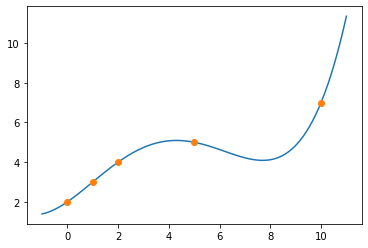

In [30]:
p_i_l = lagrange(xs,ys)
ts = np.linspace(-1,11,100)
plt.plot(ts, p_i_l(ts))
plt.plot(xs,ys, 'o')
plt.show()

O que vemos aqui é um fenômeno estranho:
apesar de os dados serem crescentes, o interpolador não é crescente!

Este é um dos problemas que atingem a interpolação de Lagrange.
Veremos porquê.

## Interpolação de Lagrange: mais Álgebra Linear

Apesar de termos formulado o problema de interpolação de Lagrange como a solução de um sistema linear,
é possível expressar a solução de outras formas.

### Polinômios especiais

Como estamos trabalhando com polinômios de grau 4 (porque temos 5 pontos),
o maior número de zeros que um tal polinômio pode ter é 4.
Aliás, é exatamente isso que garante que a solução é _única_.

Vejamos que, dados 5 pontos, existem polinômios de grau 4 que são "mais especiais" do que outros.
Especial também pode ser "simples", e por isso vamos tentar achar polinômios "mais simples".
Uma idéia nessa direção é a seguinte: para cada um dos pontos $x_i$,
existe um único polinômio $P_i$ que vale $1$ neste ponto, e $0$ nos outros 4.
Como ele vale zero em 4 pontos e tem grau 4, ele tem que ser da forma
$$ P_i(x) = C_i \prod_{j \neq i} (x - x_j), $$
onde $C_i$ é uma constante.
Ora, se $P_i(x_i) = 1$, isso dá uma equação para $C_i$:
$$ 1 = C_i \prod_{j \neq i} (x_i - x_j). $$
Assim, temos:
$$ P_i = \prod_{j \neq i} \frac{x - x_j}{x_i - x_j}.$$

Agora, note que se uma função $f$ vale $y_0 \neq 0$ em $x_0$
a _única_ forma de, usando os $P_i$, obter este valor será usando $y_0 \times P_i(x)$.

### Exercício

Deduza a fórmula _de Lagrange_ do polinômio interpolador dos pontos $(x_i, y_i)$:
$$ I(x) = \sum_{i = 0}^n \left[ y_i \prod_{j \neq i} \frac{x - x_j}{x_i - x_j} \right]. $$

### Exercício

Faça o gráfico dos 5 polinômios $P_i$ para os pontos $x = [0,1,2,5,10]$.

In [31]:
def lagrange_basis(xs):
    polinomios = []
    xs = np.array(xs)
    
    for Xi in xs:
        def p(x):
            poly = 1
            
            for Xj in xs:
                if Xj != Xi:
                    poly *= (x - Xj) / (Xi - Xj)
            
            return poly
        
        print(p(xs), Xi, xs)
        polinomios.append(lambda y: p(y))
        
    return polinomios

In [32]:
def lagrange_poly(f, xs, x):
    sum = 0

    for Xi in xs:
        def lagrange_b(X):
            lagrange = 1

            for Xj in xs:
                if Xi != Xj:
                    lagrange *= (X - Xj) / (Xi - Xj)
            return lagrange

        sum += f(Xi)*lagrange_b(x)
    return sum

In [33]:
def funcao(x):
    return 1/(x**2 + 1)

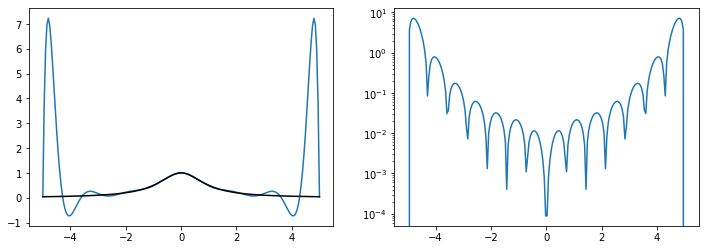

In [34]:
a = 5
b = -5
n = 15

xpontos = np.linspace(a, b, n)
pontos = np.linspace(a, b, 200)
valores = lagrange_poly(funcao, xpontos, pontos)

fig, ax = plt.subplots(ncols=2, figsize=(12,4))
ax[0].plot(pontos, valores, label='Lagrange polynomial')
ax[0].plot(pontos, funcao(pontos), color='black',label='função')

erro = abs(funcao(pontos) - valores)
ax[1].semilogy(pontos, erro)
